# Trabajo Final NLP - Clusters

In [13]:
library(fastDummies)
library(clustMixType)
library(combinat)
library(readr)
library(Rtsne)
library(Hmisc)
library(MASS)
library(mclust)
library(repr)
library(cluster)
library(circlize)
library(dendextend)
library(ggplot2)
library(FactoMineR)
library(factoextra)
library(fpc)
library(NbClust)
library(dplyr)
library(dclust)
library(ggdendro)
library(rgl)
library(ggpubr)
library(gridExtra)

### 1. Cargamos el dataset y transformamos algunas variables

In [14]:
# Cargamos el dataset original
df <- read.csv('dataset3.csv')
# Colapsamos todas las variables relacionadas al tipo de contenido empleado en cada post
cols_2_collapse = c('Image','LinkedIn_Video','External_Video','Article')
df$Article_Type = apply(df[,cols_2_collapse], 1, function(x) paste(x, collapse = ""))
# Creamos dos variables que representan el ratio de comments y reactions de un post sobre el número de followers: a la variable comments la pesamos como 100 veces
# -más relevante que la variable reaction. Esto nos permite tener una comparación de ambas variables aproximadamente en la misma medida.
df$Comment_Ratio = (log1p(df$Comment)*100/(df$Followers/1000))*100
df$Reaction_Ratio = (log1p(df$Reaction)/(df$Followers/1000))*100

# Creamos una copia de las variables que utilizaremos para el modelo que serán propiamente escaladas y convertidas en factor, según corresponda
tot_cols = c('Article_Type','hashtag_q','company_q','person_q','dominant_topic','topic_proba','text_len','Comment_Ratio','Reaction_Ratio')
clust_cols = c('Article_Type_C','hashtag_q_C','company_q_C','person_q_C','dominant_topic_C',
               'topic_proba_C','text_len_C','Comment_Ratio_C','Reaction_Ratio_C')

df[,clust_cols] = df[,tot_cols]

cat_cols = c('Article_Type_C','dominant_topic_C')
for (i in colnames(df[,cat_cols])){
    df[,i] = factor(df[,i])
}
num_cols = c('hashtag_q_C','company_q_C','person_q_C','Comment_Ratio_C','Reaction_Ratio_C','topic_proba_C','text_len_C')
for (i in colnames(df[,num_cols])){
    df[,i] = log1p(df[,i])#[,1] # Antes de ser escaladas tomamos el log1p de cada variable numérica, puesto que son bastante asimetricas
}
# Visualizamos nuestro dataframe
head(df[,clust_cols])

,Article_Type_C,hashtag_q_C,company_q_C,person_q_C,dominant_topic_C,topic_proba_C,text_len_C,Comment_Ratio_C,Reaction_Ratio_C
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0001,0.000000,0.0000000,0.0000000,responsabilidad social,0.6365768,5.493061,2.354400,0.4747774
2,0001,0.000000,0.0000000,0.6931472,tendencias,0.3852624,4.595120,3.244129,0.5155435
3,0001,0.000000,1.0986123,0.0000000,responsabilidad social,0.3852624,5.123964,3.666818,0.5545042
4,1001,0.000000,1.0986123,0.0000000,responsabilidad social,0.3852624,5.123964,3.758096,0.5465105
5,1000,1.609438,0.6931472,0.6931472,negocios,0.4121097,5.993961,3.758096,0.5465105
6,1000,0.000000,0.0000000,1.0986123,responsabilidad social,0.3576744,6.135565,3.643875,0.5440576


### 2. Modelo de clusters: validación interna y selección del modelo

2.1. Corremos el modelo para distintos valores de K y obtenemos las métricas de validación interna: 3 métodos, elbow, silhouette y within-between

In [15]:
gower.dist = daisy(df[,clust_cols], metric = c("gower"),weights = c(0.7,0.7,0.7,0.7,0,0,0.7,1,1))
n = 10
index = list()
elbow_scores = list()
avg_sil_scores = list()
wb_score = list()

for(i in 2:n){
    clusters = pam(gower.dist, k=i, metric = "mahalanobis")
    wss = cluster.stats(gower.dist,clustering = clusters$cluster, wgap = TRUE)$within.cluster.ss
    avg_sil = cluster.stats(gower.dist,clustering = clusters$cluster,silhouette = TRUE)$avg.silwidth
    wb = cluster.stats(gower.dist,clustering = clusters$cluster)$wb.ratio
    index[i-1] = i
    elbow_scores[i-1] <- wss
    avg_sil_scores[i-1] <- avg_sil
    wb_score[i-1] <- wb
}
df_scores = as.data.frame(cbind(index,elbow_scores,avg_sil_scores,wb_score))

2.2. Ploteamos los resultados de las métricas para los 3 métodos de validación anteriores 

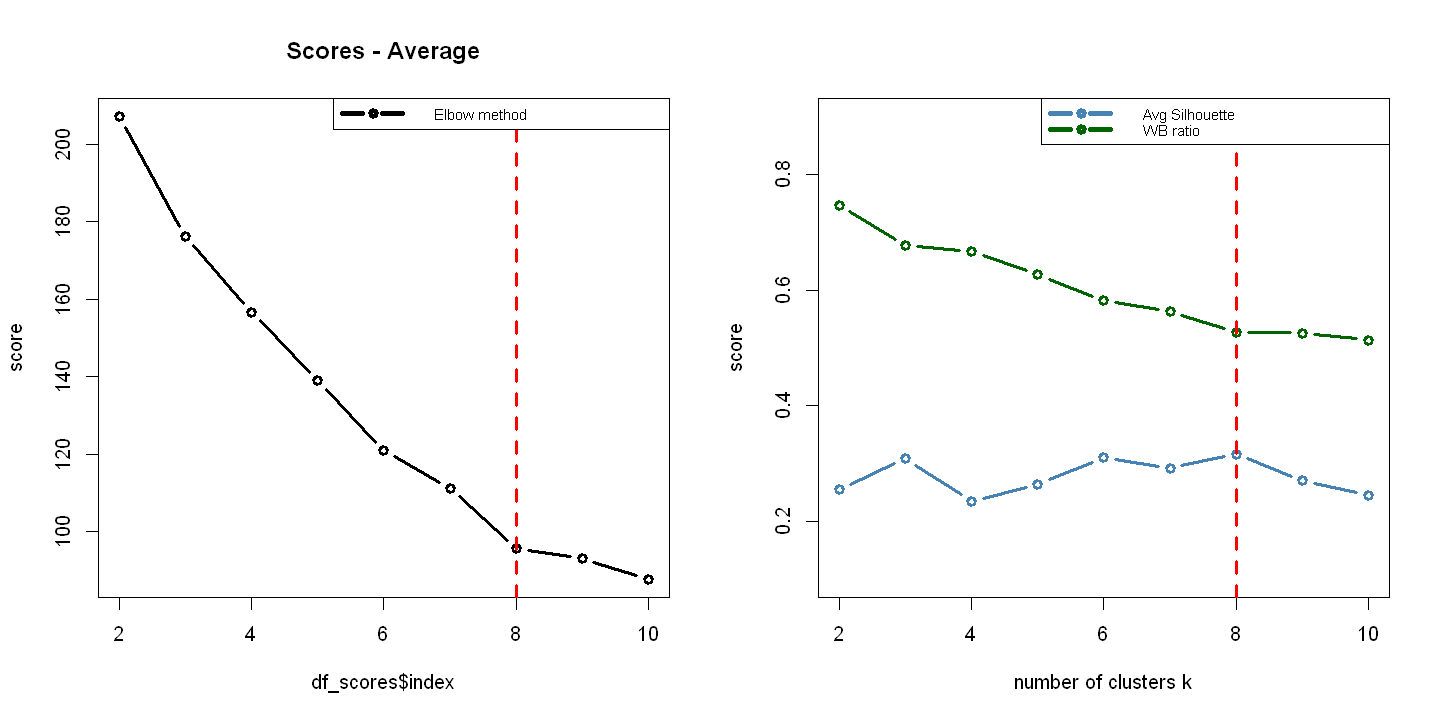

In [16]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(df_scores$index,df_scores$elbow_scores,type='b',
     col='black',lwd=3,main='Scores - Average',
     ylab='score',
     xlab=NULL)
abline(v=8,lty=2, lwd=3, col = 'red')
legend("topright", legend=c('Elbow method'),
       col=c('black'),lwd=4, lty=2:2:2, cex=0.75,bty = "o",pch=21)

plot(df_scores$index,df_scores$avg_sil_scores,type='b',
     col='steelblue',lwd=3,main=NULL,
     ylab='score',
     xlab='number of clusters k',ylim=c(0.1,0.9))
lines(df_scores$index,df_scores$wb_score,type='b',lwd=3,col='darkgreen')
abline(v=8,lty=2, lwd=3, col = 'red')
legend("topright", legend=c('Avg Silhouette','WB ratio'),
       col=c("steelblue","darkgreen"),lwd=4, lty=2:2:2, cex=0.75,bty = ".",pch=1)

2.3. De los resultados anteriores se desprende que el número óptimo de clusters es k=8

In [17]:
modelo = pam(gower.dist, k=8, metric = "mahalanobis")

2.4. Ploteamos los silhoueetes e identificamos las observaciones con valores de silhouette negativos

[1] "Silhoutte negativos para 4 clusters: 479 respectivamente"


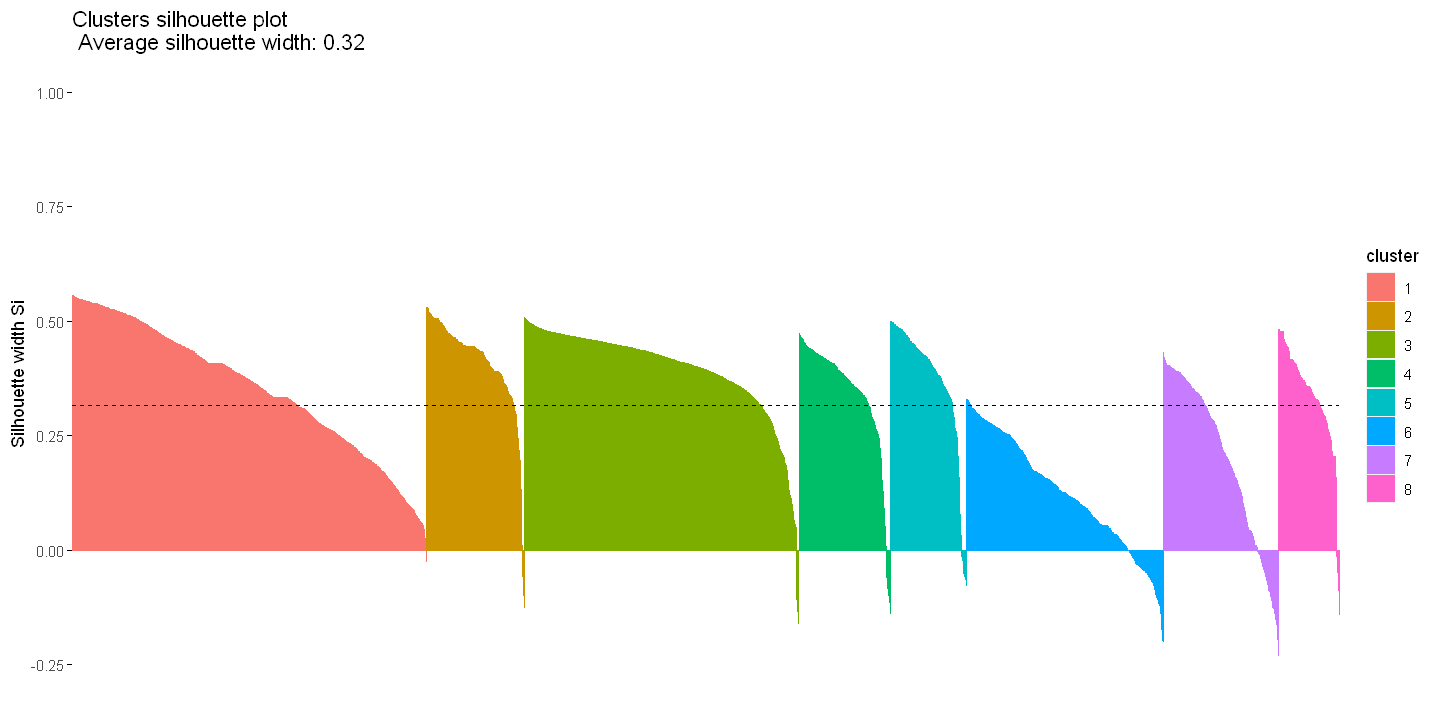

In [18]:
# Identify observation with negative silhouette
sil = silhouette(modelo$cluster, gower.dist)
neg_sil_index <- which(sil[, "sil_width"] < 0)
neg_sil = nrow(sil[neg_sil_index, , drop = FALSE])
clusters = sil[,1]
print(paste0('Silhoutte negativos para 4 clusters: ',neg_sil,' respectivamente'))
p = fviz_silhouette(sil, print.summary = FALSE)
p$layers[[2]]$aes_params$colour <- "black"

p

2.5. Creamos una función para reasignar las observaciones con silhouttes negativos y reasignamos cada una de ellas a sus clusters vecinos

In [19]:
# Creamos una función para reasignar etiquetas a las observaciones con Silhouette negativo
cluster_adjusted = function(clusters,tol){
    sil <- silhouette(clusters$cluster, gower.dist)
    neg_sil_index <- which(sil[, "sil_width"] < 0)
    
    while(length(neg_sil_index)>tol){
        #if(k<500){
            clusters$cluster[neg_sil_index] = sil[neg_sil_index,2]
            sil <- silhouette(clusters$cluster, gower.dist)
            neg_sil_index <- which(sil[, "sil_width"] < 0)
            
        #}else{break}
    }
    return(sil)
}

2.6. Ejecutamos la función y obtenemos la nueva asignación ya corregida

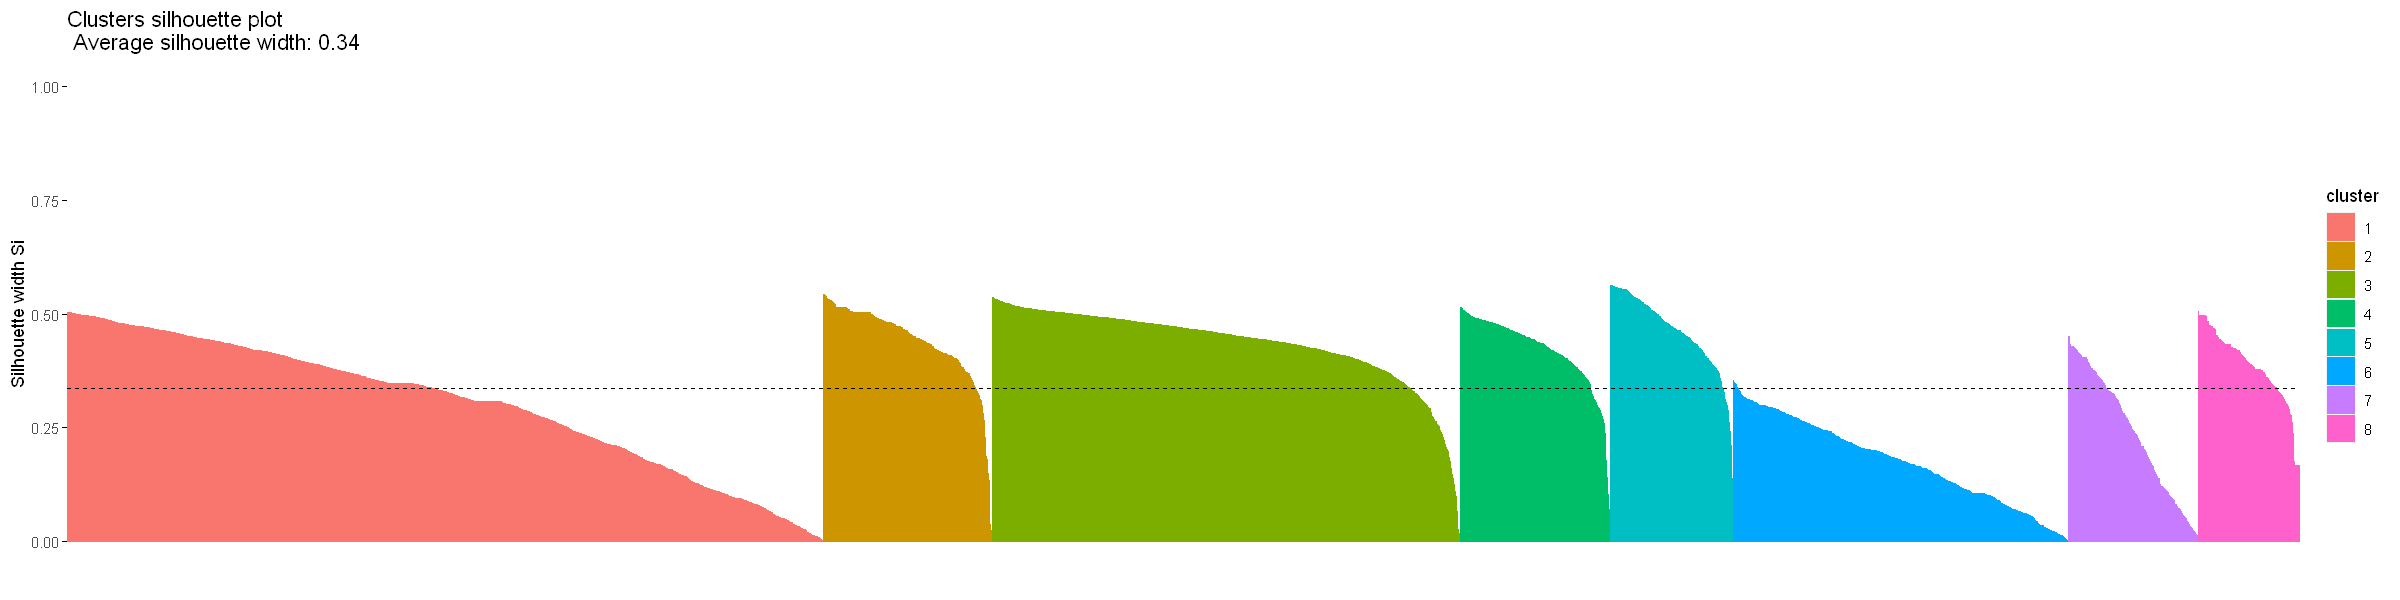

In [20]:
# Ploteamos los silhouettes de los 3 modelos de cluster: para valores grandes de k da valores más altos de avg silhouette
options(repr.plot.width=20, repr.plot.height=5)
sil = cluster_adjusted(modelo,0)
clusters = sil[,1]
p = fviz_silhouette(sil, print.summary = FALSE)
p$layers[[2]]$aes_params$colour <- "black"
p

2.7. Asignamos las etiquetas a cada observación y definimos nuestro dataset final sobre el que analizaremos los resultados

In [21]:
df['Cluster'] = clusters
cols_final = c('Cluster','Engagement_Alto',
               'Article_Type_C','dominant_topic',
               'topic_proba','text_len','hashtag_q','company_q','person_q',
               'Comment_Ratio','Reaction_Ratio')
# Juntamos los 8 clusters en 2 metaclusters de 4 cada uno según engagement alto y bajo
df$Engagement_Alto = factor(as.numeric((df$Cluster==2)|(df$Cluster==4)|(df$Cluster==7)|(df$Cluster==8)))
head(df[,cols_final],6)

,Cluster,Engagement_Alto,Article_Type_C,dominant_topic,topic_proba,text_len,hashtag_q,company_q,person_q,Comment_Ratio,Reaction_Ratio
,<dbl>,<fct>,<fct>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,0,0001,responsabilidad social,0.89,242,0,0,0,9.531806,0.6076564
2,1,0,0001,tendencias,0.47,98,0,0,1,24.639360,0.6745483
3,1,0,0001,responsabilidad social,0.47,167,0,2,0,38.127222,0.7410776
4,2,1,1001,responsabilidad social,0.47,167,0,2,0,41.866716,0.7272154
5,3,0,1000,negocios,0.51,400,4,1,1,41.866716,0.7272154
6,3,0,1000,responsabilidad social,0.43,461,0,0,2,37.239721,0.7229839
